{'subject': 16316, 'enron': 8128, 'methanol': 12195, 'meter': 12192, '988291': 3910, 'thi': 16820, 'is': 10417, 'follow': 8766, 'up': 17436, 'to': 16967, 'the': 16789, 'note': 12931, 'gave': 9062, 'you': 18281, 'on': 13114, 'monday': 12455, '00': 0, 'preliminary': 13973, 'flow': 8735, 'data': 7079, 'provid': 14150, 'by': 5700, 'daren': 7061, 'pleas': 13795, 'overrid': 13284, 'pop': 13856, 'daili': 7023, 'volum': 17712, 'present': 13991, 'zero': 18316, 'reflect': 14558, 'daily': 7024, 'act': 4089, 'can': 5791, 'obtain': 13014, 'from': 8908, 'ga': 8977, 'control': 6663, 'chang': 6056, 'need': 12738, 'asap': 4676, 'for': 8786, 'econom': 7893, 'purpos': 14214, 'hpl': 9939, 'nom': 12884, 'januari': 10514, '2001': 925, 'see': 15411, 'attach': 4759, 'file': 8645, 'hplnol': 9946, '09': 173, 'xl': 18223, 'neon': 12762, 'retreat': 14788, 'ho': 9821, 'we': 17853, 're': 14405, 'around': 4652, 'that': 16784, 'most': 12520, 'wonder': 18115, 'time': 16916, 'of': 13051, 'year': 18252, 'leader': 11292,

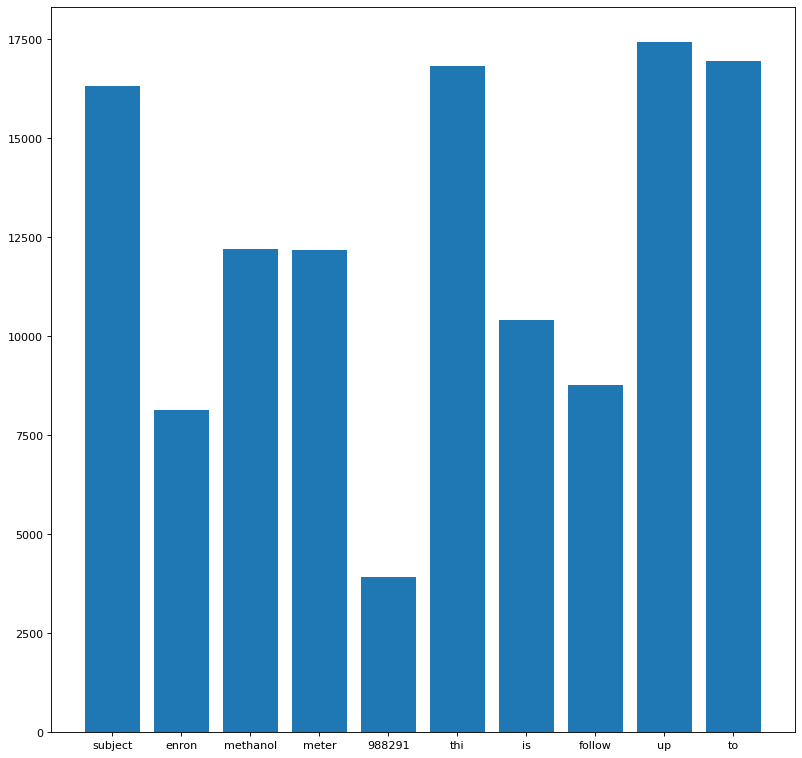

In [ ]:
import pandas as pd
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import gensim
from gensim.models import Word2Vec
import tensorflow.keras as keras
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


train_dataset = pd.read_csv("spam_ham_dataset.csv")

y_train = train_dataset['label']
x_train = train_dataset.values
pure_x_train = [x[2] for x in x_train]
spam_set_x = [x[2] for x in x_train if x[1]=="spam"]
ham_set_x = [x[2] for x in x_train if x[1]=="ham"]

#Data Preprocessing: (word stem)
stemmer = PorterStemmer()

#lemmatizer = WordNetLemmatizer()

stemmed_ham_words_x = [" ".join([stemmer.stem(o) for o in i.split(" ")]) for i in ham_set_x]

# stemmed_spam_words_x = [" ".join([stemmer.stem(o) for o in i.split(" ")]) for i in spam_set_x]
# stemmed_words_x = [" ".join([lemmatizer.lemmatize(o).replace(" ","") for o in i]) for i in pure_x_train]

#Wor2vec part/ tokenization

vectorizer = CountVectorizer()
vectorizer.fit([str(email).replace("\n"," ") for email in stemmed_ham_words_x])
vector_ham = vectorizer.transform([str(email).replace("\n"," ") for email in stemmed_ham_words_x])

print(vectorizer.vocabulary_)
print(vector_ham.shape)
stemmed_ham_tokens_x = vector_ham.toarray()
labels = list(dict(vectorizer.vocabulary_).keys())[:10]
values = list(dict(vectorizer.vocabulary_).values())[:10]
print(values)
plt.figure(figsize=(12, 12), dpi=80)
plt.bar(range(len(labels)), values, tick_label=labels)
plt.show()

# vectorizer = CountVectorizer()
# vectorizer.fit([str(email).replace("\n"," ") for email in stemmed_spam_words_x])
# vector_spam = vectorizer.transform([str(email).replace("\n"," ") for email in stemmed_spam_words_x])
# print(vectorizer.vocabulary_)
# print(vector_spam.shape)
# stemmed_spam_tokens_x = vector_spam.toarray()
# labels = list(dict(vectorizer.vocabulary_).keys())
# values = list(dict(vectorizer.vocabulary_).values())

# plt.bar(range(len(labels)), values, tick_label=labels)
# plt.show()

Data Cleaning (preprocessing)


In [1]:
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import gensim
from gensim.models import Word2Vec
import tensorflow.keras as keras
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
nltk.download('stopwords')
import re
from sklearn.model_selection import train_test_split

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"
def preprocess(text, stem=False):
    stemmer = PorterStemmer()
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

train_dataset = pd.read_csv("spam_ham_dataset.csv")
stop_words = stopwords.words('english')

y_train = train_dataset['label_num']
x_train = train_dataset['text']


#Data Preprocessing: (word stem)

stemmed_words_x = x_train.apply(lambda x: preprocess(x,True))
#Wor2vec part/ tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(stemmed_words_x)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 10000
# print("Vocabulary Size :", vocab_size)

stemmed_words_x.head().reset_index()
x_train = pad_sequences(tokenizer.texts_to_sequences(stemmed_words_x),maxlen = 50)
x_train, x_train2, y_train, y_train2 = train_test_split(x_train, y_train, test_size=0.3, random_state=0)
x_train, x_train3, y_train, y_train3 = train_test_split(x_train, y_train, test_size=0.3, random_state=0)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Model Training


In [2]:

MAX_SEQUENCE_LENGTH = 50
n_lstm = 200
drop_lstm = 0.2
embeding_dim = 16
drop_value = 0.2
n_dense = 24
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dropout(0.1))
model1.add(Dense(1, activation='relu'))
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'],validation_data=(x_valid,y_valid))
print(x_train.shape)

history = model1.fit(x_train, y_train, epochs=num_epochs, verbose=2)
early_stop = EarlyStopping(monitor='val_loss', patience=2)


(2533, 50)
Epoch 1/10
80/80 - 26s - loss: 0.6495 - accuracy: 0.7025 - 26s/epoch - 325ms/step
Epoch 2/10
80/80 - 21s - loss: 0.3346 - accuracy: 0.8393 - 21s/epoch - 261ms/step
Epoch 3/10
80/80 - 22s - loss: 0.2214 - accuracy: 0.8990 - 22s/epoch - 269ms/step
Epoch 4/10
80/80 - 21s - loss: 0.1918 - accuracy: 0.9100 - 21s/epoch - 260ms/step
Epoch 5/10
80/80 - 21s - loss: 0.1788 - accuracy: 0.9149 - 21s/epoch - 263ms/step
Epoch 6/10
80/80 - 22s - loss: 0.1748 - accuracy: 0.9184 - 22s/epoch - 271ms/step
Epoch 7/10
80/80 - 21s - loss: 0.1634 - accuracy: 0.9225 - 21s/epoch - 261ms/step
Epoch 8/10
80/80 - 21s - loss: 0.1613 - accuracy: 0.9233 - 21s/epoch - 263ms/step
Epoch 9/10
80/80 - 21s - loss: 0.1546 - accuracy: 0.9255 - 21s/epoch - 260ms/step
Epoch 10/10
80/80 - 21s - loss: 0.1520 - accuracy: 0.9280 - 21s/epoch - 263ms/step


Training of Model 2

In [6]:
from keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(128, activation='relu', input_dim=50 , return_sequences = True))
rnn.add(SimpleRNN(64, activation='relu' ,  return_sequences = False))
# Adding dropout to prevent overfitting
#rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

x_train2 = x_train2.reshape(len(y_train2),1,50)
y_train2 = np.array(y_train2).reshape(len(y_train2),1,1)
rnn.fit(x_train2, y_train2, batch_size=100, epochs=150)

Epoch 1/150
16/16 [==============================] - 3s 4ms/step - loss: 514.3083 - accuracy: 0.5509
Epoch 2/150
16/16 [==============================] - 0s 4ms/step - loss: 203.0674 - accuracy: 0.6128
Epoch 3/150
16/16 [==============================] - 0s 4ms/step - loss: 121.2827 - accuracy: 0.6649
Epoch 4/150
16/16 [==============================] - 0s 5ms/step - loss: 74.9161 - accuracy: 0.7062
Epoch 5/150
16/16 [==============================] - 0s 4ms/step - loss: 51.5174 - accuracy: 0.7622
Epoch 6/150
16/16 [==============================] - 0s 4ms/step - loss: 41.9038 - accuracy: 0.7526
Epoch 7/150
16/16 [==============================] - 0s 4ms/step - loss: 31.5492 - accuracy: 0.7880
Epoch 8/150
16/16 [==============================] - 0s 4ms/step - loss: 21.8755 - accuracy: 0.8138
Epoch 9/150
16/16 [==============================] - 0s 4ms/step - loss: 19.3440 - accuracy: 0.8260
Epoch 10/150
16/16 [==============================] - 0s 4ms/step - loss: 13.3712 - accuracy: 0.8

Training of Model 3

In [7]:
# Create the model with the best hyperparameters
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(x_train3,y_train3)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)
grid.best_params_
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(x_train3,y_train3)
# y_pred = model.predict(X_test)

# from sklearn.metrics import classification_report, accuracy_score
# printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

MultinomialNB(alpha=0.2)

Testing

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train,list(y_train))

ValueError: ignored

In [15]:



test_dataset = pd.read_csv("messages.csv",encoding='latin-1')

y_test = [True if y == 'spam' else False for y in test_dataset["label"]]
x_test = test_dataset["message"]

#Data Preprocessing: (word stem)

x_test = x_test.apply(lambda x: preprocess(x,True))
#Wor2vec part/ tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_test)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
# print("Vocabulary Size :", vocab_size)

x_test.head().reset_index()
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),maxlen = 50)


# model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'],validation_data=(x_test,y_test))
y1 = model1.predict(x_test)
var1=(y1>0.5)
x_test1 = x_test.reshape(len(y_test),1,50)

y2 = rnn.predict(x_test1)
var2=(y2>0.5)

y3 = model.predict(x_test)
var3=(y3>0.5)



phase de Test

In [33]:
cpt = 0
tot = len(var1)
print(y1.shape)
print(len(y_test))
LSTM = []
RNN = []
MNB = []
for i in range(len(var1)):
  if list(var1[i]).count([y_test[i]])/50 > 0.10 :
    cpt += list(var1[i]).count([y_test[i]])/50 > 0.50 
  LSTM.append(list(var1[i]).count([y_test[i]])/50 > 0.50 )
  # print(var1[i][0])
print("LSTM: ", cpt/tot)

cpt = 0
tot = len(var2)
print(y2.shape)

for i in range(len(var2)):
  if var2[i][0] == y_test[i] :
    cpt += 1
  RNN.append(var2[i][0] == y_test[i])
  # print(var1[i][0])
print("RNN: ", cpt/tot)


cpt = 0
tot = len(var3)
print(y3.shape)
for i in range(len(var3)):
  if var3[i] == y_test[i] :
    cpt += 1
  MNB.append(var3[i]== y_test[i])
  # print(var1[i][0])
print("MNB: ", cpt/tot)

EL_cpt = 0
for i in range(len(y_test)):
  el = [y_test[i] if list(var1[i]).count([y_test[i]])/50 > 0.50 else not y_test[i],var2[i][0],var3[i]]

  if(el.count(y_test[i]) >= 2): EL_cpt += 1
print("EL: ",EL_cpt/tot)


(2893, 50, 1)
2893
LSTM:  0.9464223988938818
(2893, 1)
RNN:  0.6799170411337712
(2893,)
MNB:  0.4870376771517456
EL:  0.805737988247494
